In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import datetime
import gpflow as gf
from rich import print
from collections import namedtuple
from sklearn.metrics import mean_absolute_error
import tensorflow_probability as tfp
tfd = tfp.distributions

2023-11-15 17:27:53.816312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 17:27:54.052236: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-15 17:27:56.791869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/share/soft/anaconda/anaconda3/envs/tf/lib/libfabric::/usr/local/cuda/lib64
2023-11-15 17:27:56.792084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvin

In [2]:
# set up a global plt style for the script
# plt.style.use('classic')
plt.rcParams.update({
        "font.size": 11,
        "text.usetex": True,
        "font.family": "serif",
        "legend.fontsize": 'small',
        })

Introduction
=========

# library modules

In [3]:
def inspect_date_format(df):
    """ identifying rows with wrong date formatting """
    
    m = pd.to_datetime(df['Date'], format="%d/%m/%Y", errors='coerce').isna()
    wrong_dates = df.loc[m, 'Date'].unique().tolist()
    print(f"Detected wrong date format: {wrong_dates}")
    
    # pinpoint the rows with such incorrect dates
    for i in wrong_dates:
        print(f"row index with wrong dates '{i}' ==> {df[df['Date'] == i].index}")

In [4]:
def date_formatting(df):
    """ recipe for datetime indexing of dataframe """
    
    return (df
            .assign(datetime = pd.to_datetime(df['Date'], format="%d/%m/%Y"))  
            .set_index('datetime')
            .drop(['Day', 'Date'], axis=1)
           )

In [5]:
def inspect_missing_data(df, option):
    """ look for months with missing records from the history 
    
    args:
        df: the query dataframe
        
    return:
        information (stdout) as to missing months
    """
    
    if option == 'missing_month':
        s = df.resample('MS').size()
        mm = s[s == 0].index.to_period('M')
        num = len(mm)
        print(f"Total number of months with missing records: {num}")
        print("Missing months are: \n", mm)
        
    elif option == 'nan':
        print(data.isna().sum())
    else:
        print('Wrong option')

In [6]:
def inspect_duplicates(df):
    """ check if exising duplicated data """
    
    num = data.duplicated().sum()
    print(f"Total number of duplicates: {num}")
    print(f"If existing, display duplicated rows:\n\n {data[data.duplicated()]}")

In [7]:
def boxplot_annual_averge(df):
    """ Reproduce Figure 1
    
    note:
        Figure 1: Average debts over years
    """
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.boxplot(
        data=df, 
        y='totalU', 
        x='Year', 
    )
    ax.set_ylabel('Total Debts')
    ax.yaxis.set_major_formatter('£{x:,.2f}')
    ax.grid(which='both', ls=':')

In [8]:
def plot_monthly_debt_history(df):
    """ Reproducing Figure 2 
    
    note:
        Figure 2: the total debts from all lenders over months and years
    """

    fig, axs = plt.subplots(
        nrows=3, ncols=4, 
        sharex=True, sharey=True,
        layout="constrained",
        figsize=(10, 9))

    monthly_data_gen = (df[df['Year'] == year] for year in range(2013, 2024))
    year_gen = iter(range(2013, 2024))

    for row in range(4):
        for col in range(4):
            try: 
                year_average_plot(ax=axs[row, col], df=next(monthly_data_gen), title=next(year_gen))
            except Exception:
                pass

    fig.delaxes(axs[2][3])

In [66]:
def plot_total_debt_history(df):
    """ Reproduce Figure 3 
    
    note:
        Figure 3: Total monthly debts from all lenders starting from October 2013
    """
    
    fig, ax  = plt.subplots(figsize=(8, 6))
    ax.plot(df.index, df['totalU'], color='black', 
            ls = '-', marker='.', 
            mfc='salmon', mec='salmon',
           label='historical observation')
    ax.yaxis.set_major_formatter('£{x:,.2f}')
    ax.set_ylabel('Total Debts')
    ax.set_xlabel('Months starting at Oct 2013')
    ax.legend(loc='upper left')

In [10]:
def year_average_plot(ax, df, title):
    """ A template for creating Figure 2.
    
    Control the plotting style of a single axe in creating Figure2.
    It corresponds the monthly total debts in each year.
    
    args:
        ax: Matplotlib axe
        df: the data frame
        title: which year
    """
    # plotting style
    ax.plot(df.Month, df.totalU, 
            color='black', marker='o', 
            ls='-', lw=2, mfc = 'salmon', 
            mec = None, markersize=8)

    # x-axis formatting
    ax.set_xlim(0, 13)
    ax.xaxis.set_major_locator(
        mpl.ticker.FixedLocator(np.arange(1,13)))
    
    # y-axis formatting
    ax.set_ylim(200000, 800000)
    ax.yaxis.set_major_locator(
        mpl.ticker.FixedLocator(
            [300000, 400000, 500000, 600000, 700000]))
    ax.yaxis.set_major_formatter('£{x:,.2f}')
    ax.yaxis.set_minor_locator(
        mpl.ticker.AutoMinorLocator(n=2))

    ax.grid(which='both', ls=':')
    ax.set_title(f'{title}')

In [ ]:
def which_lender_history(df, lender_name):
    df[lender_name].plot(xlabel='Year', ylabel='Debt', legend=True)

In [11]:
TargetTransform = namedtuple('TargetTransform', ['mean_value', 'scale', 'split_index'])

In [12]:
def prepare_TrainTest_data(df, split=0.8):

    """ prepare the training and test data given a split
    
    args:
        split: split ratio
    """
    y = df[['totalU']].to_numpy().reshape(-1, 1)
    y = y - y.mean()
    X = (df.index.year + df.index.month / 12).to_numpy().reshape(-1, 1)
    
    # change unit to million
    y = y / 1000_000
    
    split_index = int(split * len(df))
    x_train, y_train = X[:split_index], y[:split_index]
    x_test, y_test = X[split_index:], y[split_index:]
    tt = TargetTransform(mean_value=y.mean(), scale=1000_000, split_index=split_index)

    return x_train, y_train, x_test, y_test, tt

In [13]:
def gp_modelling(X, y):
    
    # get the zero-mean process
    model = gf.models.GPR(
        (X, y),
        kernel=gf.kernels.SquaredExponential()
        + gf.kernels.Periodic(gf.kernels.SquaredExponential(), period=1.0),
        # likelihood=gpflow.likelihoods.Gaussian(scale=gpflow.functions.Polynomial(degree=2)),
        # noise_variance = 10_000,
    )

    opt = gf.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    
    return model

In [14]:
def gp_plotting(X_plot, y_mean, y_var, tt):
    
    # noisy prediction
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)
    y_lower_3sigma = y_mean - 3 * np.sqrt(y_var)
    y_upper_3sigma = y_mean + 3 * np.sqrt(y_var)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    # ground truth 
    ax.plot(x_train, y_train, 
            color="green", label="observation", ls='',
             marker='x', ms=5, mew=1.5,
             mec = 'coral', mfc = 'coral')
    
    # ground truth
    ax.plot(x_test, y_test, 
            color="green", ls='',
             marker='x', ms=5, mew=1.5,
             mec = 'coral', mfc = 'coral')
    
    # mean function
    ax.plot(X_plot, y_mean, "-", color="C0", label="mean prediction", zorder=10)

    # 95% confidence interval
    ax.fill_between(
        X_plot[:, 0], y_lower[:, 0], y_upper[:, 0], color="lightblue", alpha=0.3, label='predictive interval')

    # 99% confidence interval
    ax.fill_between(
        X_plot[:, 0], y_lower_3sigma[:, 0], y_upper_3sigma[:, 0], color="lightblue", alpha=0.2)

    ax.axvline(x=x_test[0], ymin=0, ymax=1, c='green', lw=0.75, ls='--', label='train/test split')
    ax.axvline(x=x_test[-1], ymin=0, ymax=1, c='purple', lw=0.75, ls='--', label='future forecast')
    ax.axvline(x=X_plot[-1], ymin=0, ymax=1, c='r', lw=0.75, ls='--', label='current date: 2023/11')
    
    ax.set_ylabel('Scaled Total Debts (in million pounds)')
    ax.grid(ls=':')
    ax.legend()

In [15]:
def get_date_month_index(df):
    """ get the index for associated month in datetime object """
    
    today = datetime.datetime.now()
    current_month = today.year + today.month / 12
    
    # the start month of the observation
    start = df.index.min()
    start_month = start.year + start.month / 12
    
    # the last month of the observation
    last = df.index.max()
    last_month = last.year + last.month / 12
    
    return current_month, start_month, last_month

In [78]:
def Loglikelihood(y_true, y_pred):
    """ compute log-likelihood """
    
    return y_pred.log_prob(y_true)

In [ ]:
def evaluate_metrics(x_test, y_test, f_mean, f_var):
    """ evaluate the model performance (averaged) on test data 
    
    metrics:
        1. MAE;
        2. Test log likelihood
        3. PICP
        4. Width of predictive interval
    """
    metrics = {}
    
    f_mean, f_var = model.predict_f(x_test, full_cov=False)
    y_pred_dist = tfd.Normal(loc=f_mean, scale=np.sqrt(f_var))
    test_NLL = Loglikelihood(y_true=y_test, y_pred=y_pred_dist)

    lb = f_mean - 2 * np.sqrt(f_var)
    ub = f_mean + 2 * np.sqrt(f_var)
    
    PICP = np.sum((y_test > lb) & (y_test < ub)) / len(f_mean)    
    metrics['mae'] = mean_absolute_error(y_true=y_test, y_pred=f_mean)
    metrics['interval_width'] = np.mean(np.sqrt(f_var))
    metrics['log_likelihood'] = np.mean(test_NLL)
    metrics['PICP'] = PICP
    return metrics

In [ ]:
def save_a_plot(fname, save_dir):
    plt.gcf()
    plt.savefig(fname=os.path.join(save_dir, fname),
                dpi=300,
                format='pdf',
                bbox_inches='tight')
    plt.close()

# Data pre-processing and cleaning

In [16]:
## import data

In [17]:
data = pd.read_csv('../data/raw/smedebtsu.csv')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     84 non-null     object 
 1   Day      84 non-null     int64  
 2   Month    84 non-null     int64  
 3   Year     84 non-null     int64  
 4   LenderA  84 non-null     float64
 5   LenderB  84 non-null     float64
 6   LenderC  84 non-null     float64
 7   LenderD  84 non-null     int64  
 8   LenderE  84 non-null     float64
 9   LenderF  84 non-null     float64
 10  LenderG  84 non-null     float64
 11  LenderH  84 non-null     float64
 12  LenderI  84 non-null     float64
 13  LenderJ  84 non-null     float64
 14  LenderK  84 non-null     float64
 15  totalU   84 non-null     float64
dtypes: float64(11), int64(4), object(1)
memory usage: 10.6+ KB


## clean date format

In [19]:
inspect_date_format(data)

Detected wrong date format: ['04/042022', '02/052022']

row index with wrong dates '04/042022' ==> Index([73], dtype='int64')

row index with wrong dates '02/052022' ==> Index([74, 75], dtype='int64')

In [20]:
# correct wrong date formats in the raw data

data.loc[73, 'Date'] = "04/04/2022"
data.loc[74, 'Date'] = "02/05/2022"
data.loc[75, 'Date'] = "02/05/2022"

In [21]:
data = date_formatting(data)

In [22]:
data.head()

,Month,Year,LenderA,LenderB,LenderC,LenderD,LenderE,LenderF,LenderG,LenderH,LenderI,LenderJ,LenderK,totalU
datetime,,,,,,,,,,,,,,
2013-10-13,10,2013,74349.0,70109.93,11477.84,4884,0.0,61763.24,0.0,0.0,2442.00,0.0,2981.00,228007.01
2013-11-13,11,2013,73535.0,66083.05,9607.84,5170,0.0,61763.24,2563.0,0.0,2422.09,0.0,6844.09,227988.31
2013-12-10,12,2013,71027.0,93500.00,14300.00,4950,0.0,59400.00,12232.0,0.0,2640.00,0.0,7150.00,265199.00
2014-01-23,1,2014,0.0,15741.00,14300.00,3300,262944.0,0.00,3168.0,0.0,0.00,0.0,0.00,299453.00
2014-03-05,3,2014,0.0,14850.00,13200.00,3476,254177.0,0.00,4400.0,0.0,0.00,0.0,0.00,290103.00


## check missing data

In [23]:
inspect_missing_data(data, option='nan')

Month      0
Year       0
LenderA    0
LenderB    0
LenderC    0
LenderD    0
LenderE    0
LenderF    0
LenderG    0
LenderH    0
LenderI    0
LenderJ    0
LenderK    0
totalU     0
dtype: int64

In [24]:
# data.query('data.isna()')

In [25]:
inspect_missing_data(data, option='missing_month')

Total number of months with missing records: 33

Missing months are: 
 PeriodIndex(['2014-02', '2015-06', '2015-07', '2015-09', '2016-03', '2016-04',
             '2017-06', '2017-08', '2018-01', '2018-02', '2018-04', '2018-06',
             '2018-08', '2018-10', '2019-02', '2019-06', '2020-01', '2020-05',
             '2020-07', '2020-09', '2020-10', '2020-11', '2021-01', '2021-02',
             '2021-03', '2021-05', '2021-06', '2021-08', '2022-02', '2022-06',
             '2022-07', '2022-12', '2023-01'],
            dtype='period[M]', name='datetime')

**Conclusion**: 

currently, there is no missing data. However, in the cases there are, we can show the places for missing data

## check duplicated data

In [26]:
inspect_duplicates(data)

Total number of duplicates: 0

If existing, display duplicated rows:

 Empty DataFrame
Columns: [Month, Year, LenderA, LenderB, LenderC, LenderD, LenderE, LenderF, LenderG, LenderH, LenderI, LenderJ, 
LenderK, totalU]
Index: []

# data visualization

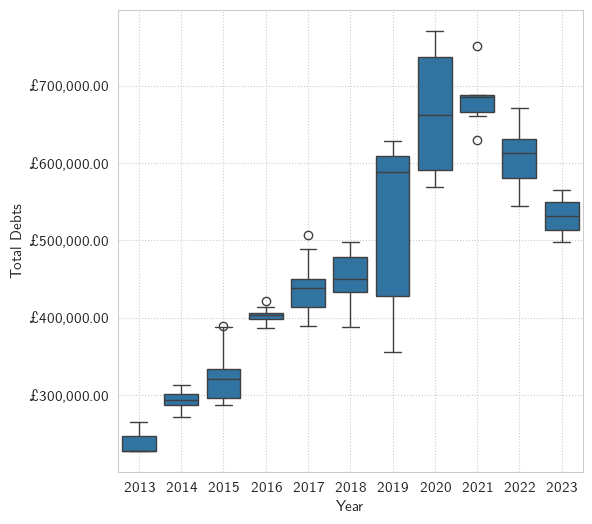

In [27]:
# reproduce "Figure 1: Figure 1: Average debts over years"
boxplot_annual_averge(data)

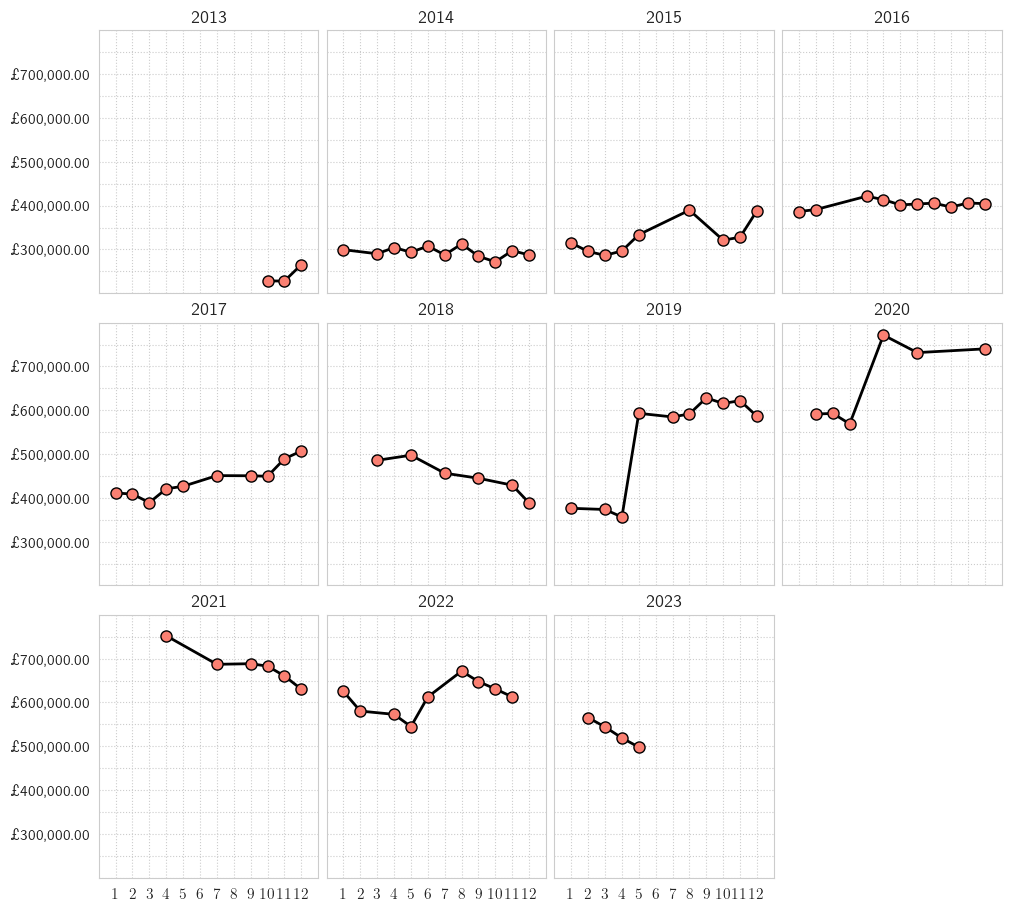

In [28]:
# reproduce "Figure 2: The total debts from all lenders over months and years"
plot_monthly_debt_history(data)

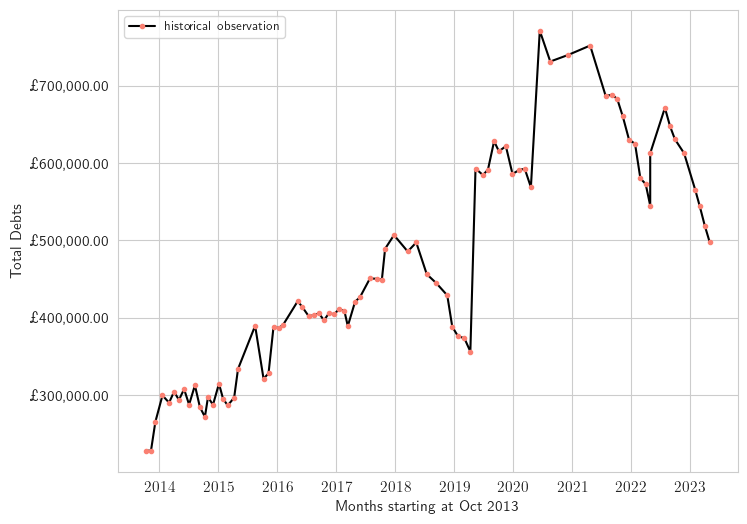

In [67]:
# reproduce "Figure 3: Total monthly debts from all lenders starting from October 2013"
plot_total_debt_history(data)

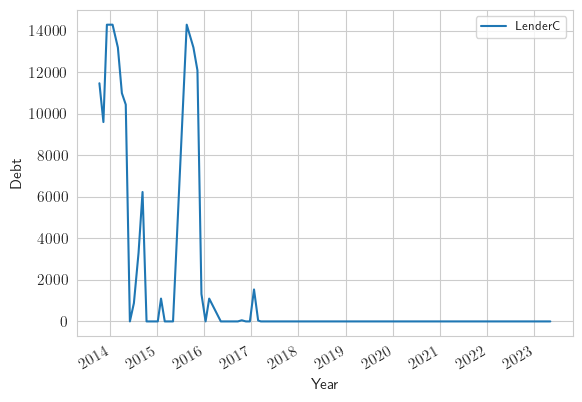

In [75]:
which_lender_history(data, 'LenderC')

# predictive modelling

In [34]:
x_train, y_train, x_test, y_test, tt = prepare_TrainTest_data(data, split=0.95)

In [35]:
current_month, start_month, last_month = get_date_month_index(data)

In [36]:
X_plot = np.linspace(start=start_month, stop=current_month, num=200).reshape(-1, 1)

In [37]:
model = gp_modelling(x_train, y_train)

2023-11-15 17:28:11.098147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 17:28:13.168755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10771 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:04:00.0, compute capability: 3.7
2023-11-15 17:28:13.170146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10787 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:05:00.0, compute capability: 3.7
2023-11-15 17:28:13.171485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10787 MB m

In [38]:
gf.utilities.print_summary(model, "notebook")

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.01747
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.64407
GPR.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.00072
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.71626
GPR.kernel.kernels[1].period,Parameter,Softplus,,True,(),float64,1.07198
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00095


In [39]:
y_mean, y_var = model.predict_y(X_plot)

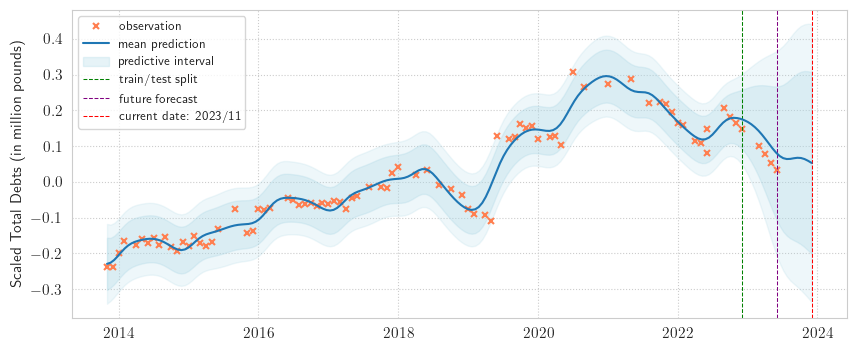

In [40]:
gp_plotting(X_plot, y_mean, y_var, tt)

In [92]:
metrics_dict = evaluate_metrics(x_test, y_test, f_mean, f_var)

In [93]:
print(pd.DataFrame(data = metrics_dict, index=[0]))

mae  interval_width  log_likelihood  PICP
0  0.041042        0.065195        1.637704   1.0

## Dynamic models in an autoregressive scheme